# ISMRM 2021 Software Demo: 
## Neural Networks in BART

This tutorial uses the BART command-line inteface (CLI) (http://mrirecon.github.io/bart/) and presents how to train and apply predefined neural networks using BART.

+ **PART I**: Simple example network for MNIST dataset
 1. Prepare dataset
 2. Train a neural network with BART
 3. Evaluate it
 4. Apply it


+ **PART II**: Application of Variational Network and MoDL
 1. Prepare dataset
 2. Apply network

**Authors**: [Moritz Blumenthal](mailto:moritz.blumenthal@med.uni-goettingen.de); [Nick Scholand](mailto:nick.scholand@med.uni-goettingen.de); [Christian Holme](mailto:christian.holme@med.uni-goettingen.de).

**Presenter**: [Moritz Blumenthal](mailto:moritz.blumenthal@med.uni-goettingen.de).

**Institution**: University Medical Center Göttingen

# Setup Environment (BART + Data)

### 0.1a BART on a Local System

If you run this notebook on your local machine, make sure that **TOOLBOX_PATH** points to your BART directory and that your local BART follows the branch **nn_ismrm2021**.

For fast inference and training on the CPU, we recommend to compile with the compile flags:
* OPENBLAS=1 - to directly link against OpenBLAS and not the system BLAS library
* BLAS_THREADSAFE=1 - to allow calling BLAS from multiple threads in parallel (which might give race conditions for some BLAS libraries)

Depending on your system, it might be usefull to restrict the number of threads to the number of physical cores by setting **OMP_NUM_THREADS**.

In [1]:
%env TOOLBOX_PATH=/home/moritz/Bart/bart
%env OMP_NUM_THREADS=4

env: TOOLBOX_PATH=/home/moritz/Bart/bart
env: OMP_NUM_THREADS=4


### 0.1b BART on Google Colab

The next cells will setup BART on Google Colab. For a detailed explanation, see the **How to Run BART on Google Colaboratory** in this repository. Skip this cells if you want to run this notebook on your local machine.

This tutorial does not need a GPU instance, but you can use one:

- Go to Edit → Notebook Settings
- Choose GPU from Hardware Accelerator drop-down menu


In [2]:
%env TOOLBOX_PATH=/content/bart

env: TOOLBOX_PATH=/content/bart


In [3]:
%%bash

# Use CUDA 10.1 when on Tesla K80


# Estimate GPU Type
GPU_NAME=$(nvidia-smi --query-gpu=gpu_name --format=csv,noheader)

echo "GPU Type:"
echo $GPU_NAME

if [ "Tesla K80" = "$GPU_NAME" ];
then
    echo "GPU type Tesla K80 does not support CUDA 11. Set CUDA to version 10.1."

    # Change default CUDA to version 10.1
    cd /usr/local
    rm cuda
    ln -s cuda-10.1 cuda
else
    echo "Current GPU supports default CUDA-11."
    echo "No further actions are necessary."
fi

echo "GPU Information:"
nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
nvcc --version

GPU Type:
Tesla T4
Current GPU supports default CUDA-11.
No further actions are necessary.
GPU Information:
name, driver_version, memory.total [MiB]
Tesla T4, 460.32.03, 15109 MiB
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [4]:
%%bash

# Install BARTs dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Clone Bart
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null


In [5]:
%%bash

BRANCH=nn_ismrm2021

cd bart

# Switch to desired branch of the BART project
git checkout $BRANCH

# Define specifications 
COMPILE_SPECS=" PARALLEL=1
                CUDA=1
                CUDA_BASE=/usr/local/cuda
                CUDA_LIB=lib64
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

make &> /dev/null

Branch 'nn_ismrm2021' set up to track remote branch 'nn_ismrm2021' from 'origin'.


Switched to a new branch 'nn_ismrm2021'


### 0.2 Set Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BARTs command line interface inside of a ipyhton jupyter-notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [6]:
import os
import sys

os.environ['PATH'] = os.environ['TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['TOOLBOX_PATH'] + "/python/")

import cfl
import numpy as np

from matplotlib import pyplot as plt
from IPython.display import Image

### 0.3 Download Data and Weights

Together with this notebook, we provide some testing data and some pretrained weights. To follow this notebook, please download the data and unzip them in the current working directory:

In [7]:
%%bash

[ ! -f data_weights.zip ] && wget -q https://github.com/mrirecon/bart-workshop/raw/master/ismrm2021/neural_networks/data_weights.zip
unzip -n data_weights.zip

Archive:  data_weights.zip
   creating: data/
  inflating: data/kspace_fs.cfl      
  inflating: data/kspace_fs.hdr      
  inflating: data/pattern_po_4.cfl   
  inflating: data/pattern_po_4.hdr   
  inflating: data/test_images.gz     
  inflating: data/test_labels.gz     
  inflating: data/train_images.gz    
  inflating: data/train_labels.gz    
   creating: data/.ipynb_checkpoints/
   creating: weights/
  inflating: weights/mnist_pretrained.hdr  
  inflating: weights/modl.cfl        
  inflating: weights/modl.hdr        
  inflating: weights/varnet.cfl      
  inflating: weights/varnet.hdr      
  inflating: weights/mnist_pretrained.cfl  
   creating: weights/.ipynb_checkpoints/
  inflating: convert_mnist.py        
  inflating: mnist_example.png       
  inflating: mnist_graph.png         


# PART I: MNIST-Example

We train a network to map 28x28 images of handwritten digits to the corresponding labels:

$$ Net: (Image, Weights) \mapsto Labels $$ 

![](mnist_example.png)

### BART nnet

To **train**, **evaluate** or **apply** generic neural networks mapping one input tensor to one output tensor, we can use the `bart nnet` command. It creates a non-linear operator representing the network selected by the `--network` option. The command is provided three files, i.e.
* the input;
* the weights;
* the output/reference.

Let us have a look at the help:

In [8]:
%%bash

bart nnet -h

Usage: nnet [-a,--apply] [-e,--eval] [-t,--train] [-g,--gpu] [-b,--batch-size d] [-l,--load <file>] [-N,--network ...] [-U,--unet-segm ...] [--train-loss ...] [--valid-loss ...] [--valid-data ...] [-T,--train-algo ...] [--adam ...] [--load-memory] [--export-graph <string>] <input> <weights> <output>

Trains or applies a neural network.

-a,--apply                   apply nnet
-e,--eval                    evaluate nnet
-t,--train                   trains network
-g,--gpu                     run on gpu
-b,--batch-size batchsize    size of mini batches
-l,--load <weights-init>     load weights for continuing training
-N,--network ...             select neural network
-U,--unet-segm ...           configure U-Net for segmentation
--train-loss ...             configure the training loss
--valid-loss ...             configure the validation loss
--valid-data ...             provide validation data
-T,--train-algo ...          configure general training parmeters
--adam ...                   c

In [9]:
%%bash

bart nnet --network h

Usage of sub-option: -N,--network [M,mnist],[U=d,unet-segm=d]

Sub-options: select neural network

M,mnist               use basic MNIST Network
U,unet-segm=labels    use U-Net for segmentation
h                     help


## 1.1 Prepare MNIST Dataset

Before we can train our network, we convert the MNIST dataset to the BART file format, i.e. the images are stored as complex floats. The labels are converted to one-hot encoded \*.cfl file. For this step. we provide a short python script, which is run in the next cell. For this tutorial, we also extract a smaller dataset based on the first 200 examples from the original MNIST dataset. We prefix the corresponding data with s*.

In [10]:
%%bash

echo "GZ files:"
ls data/*.gz

python convert_mnist.py

bart extract 2 0 200 data/test_images data/stest_images 
bart extract 2 0 200 data/train_images data/strain_images 

bart extract 1 0 200 data/test_labels data/stest_labels
bart extract 1 0 200 data/train_labels data/strain_labels 

echo ""
echo "CFL files:"
ls data/s*.hdr

GZ files:
data/test_images.gz
data/test_labels.gz
data/train_images.gz
data/train_labels.gz

CFL files:
data/stest_images.hdr
data/stest_labels.hdr
data/strain_images.hdr
data/strain_labels.hdr


tcmalloc: large alloc 1505288192 bytes == 0x55a29298a000 @  0x7f61342861e7 0x55a271c458d8 0x55a271cbf2ea 0x55a271c52cc4 0x55a271c13f30 0x55a271c13b09 0x55a271cbebe1 0x55a271c974b7 0x55a271c9d540 0x55a271cbf611 0x55a271c12b59 0x55a271c12a50 0x55a271c86be0 0x55a271c1430a 0x55a271c823b5 0x55a271c814ae 0x55a271c811b3 0x55a271d4b182 0x55a271d4b4fd 0x55a271d4b3a6 0x55a271d22723 0x55a271d223cc 0x7f6133070bf7 0x55a271d222aa


Let us have a look at the dataset to understand it. The labels are stored one-hot encoded, i.e. for each image a vector of size 10 is provided having a 1 at the index corresponding to the digit in the image:

Input Images (data/stest_images):
# Dimensions
28 28 200 1 1 1 1 1 1 1 1 1 1 1 1 1 



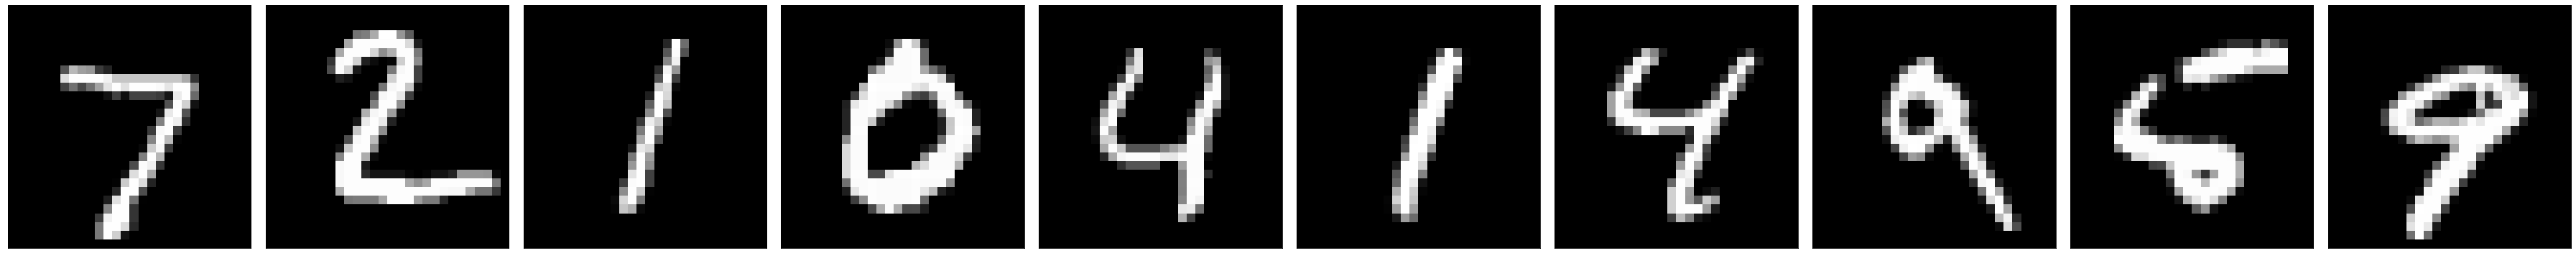


Output Labels (data/stest_labels):
# Dimensions
10 200 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [11]:
!echo "Input Images (data/stest_images):"
!head -n2 data/stest_images.hdr
!echo ""

images = cfl.readcfl("data/stest_images")[:,:,:10]

fig, axs = plt.subplots(1, 10, figsize=(50,5))
for i in range(10):
    axs[i].imshow(np.real(images[:,:,i]), cmap="gray")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
plt.tight_layout()
plt.savefig("mnist_example.png")
plt.show()

!echo ""
!echo "Output Labels (data/stest_labels):"
!head -n2 data/stest_labels.hdr
!echo ""

labels = cfl.readcfl("data/stest_labels")[:,:10]
print(np.real(labels.transpose([1, 0])))


## 1.2 Train the MNIST Network

When we train the network, we search the minium of $$Loss(Net(Image, Weights), Labels)$$ with respect to the weights. When we choose the `--train` option of the `bart nnet` command, we first create a non-linear operator (nlop) representing $Net(Image, Weights)$. This nlop is then chained into an nlop computing the $Loss$. To minimize the $Loss$, we use gradient based methods.

For visualization, we can export the nlop as a graph file using the `--export-graph` option:

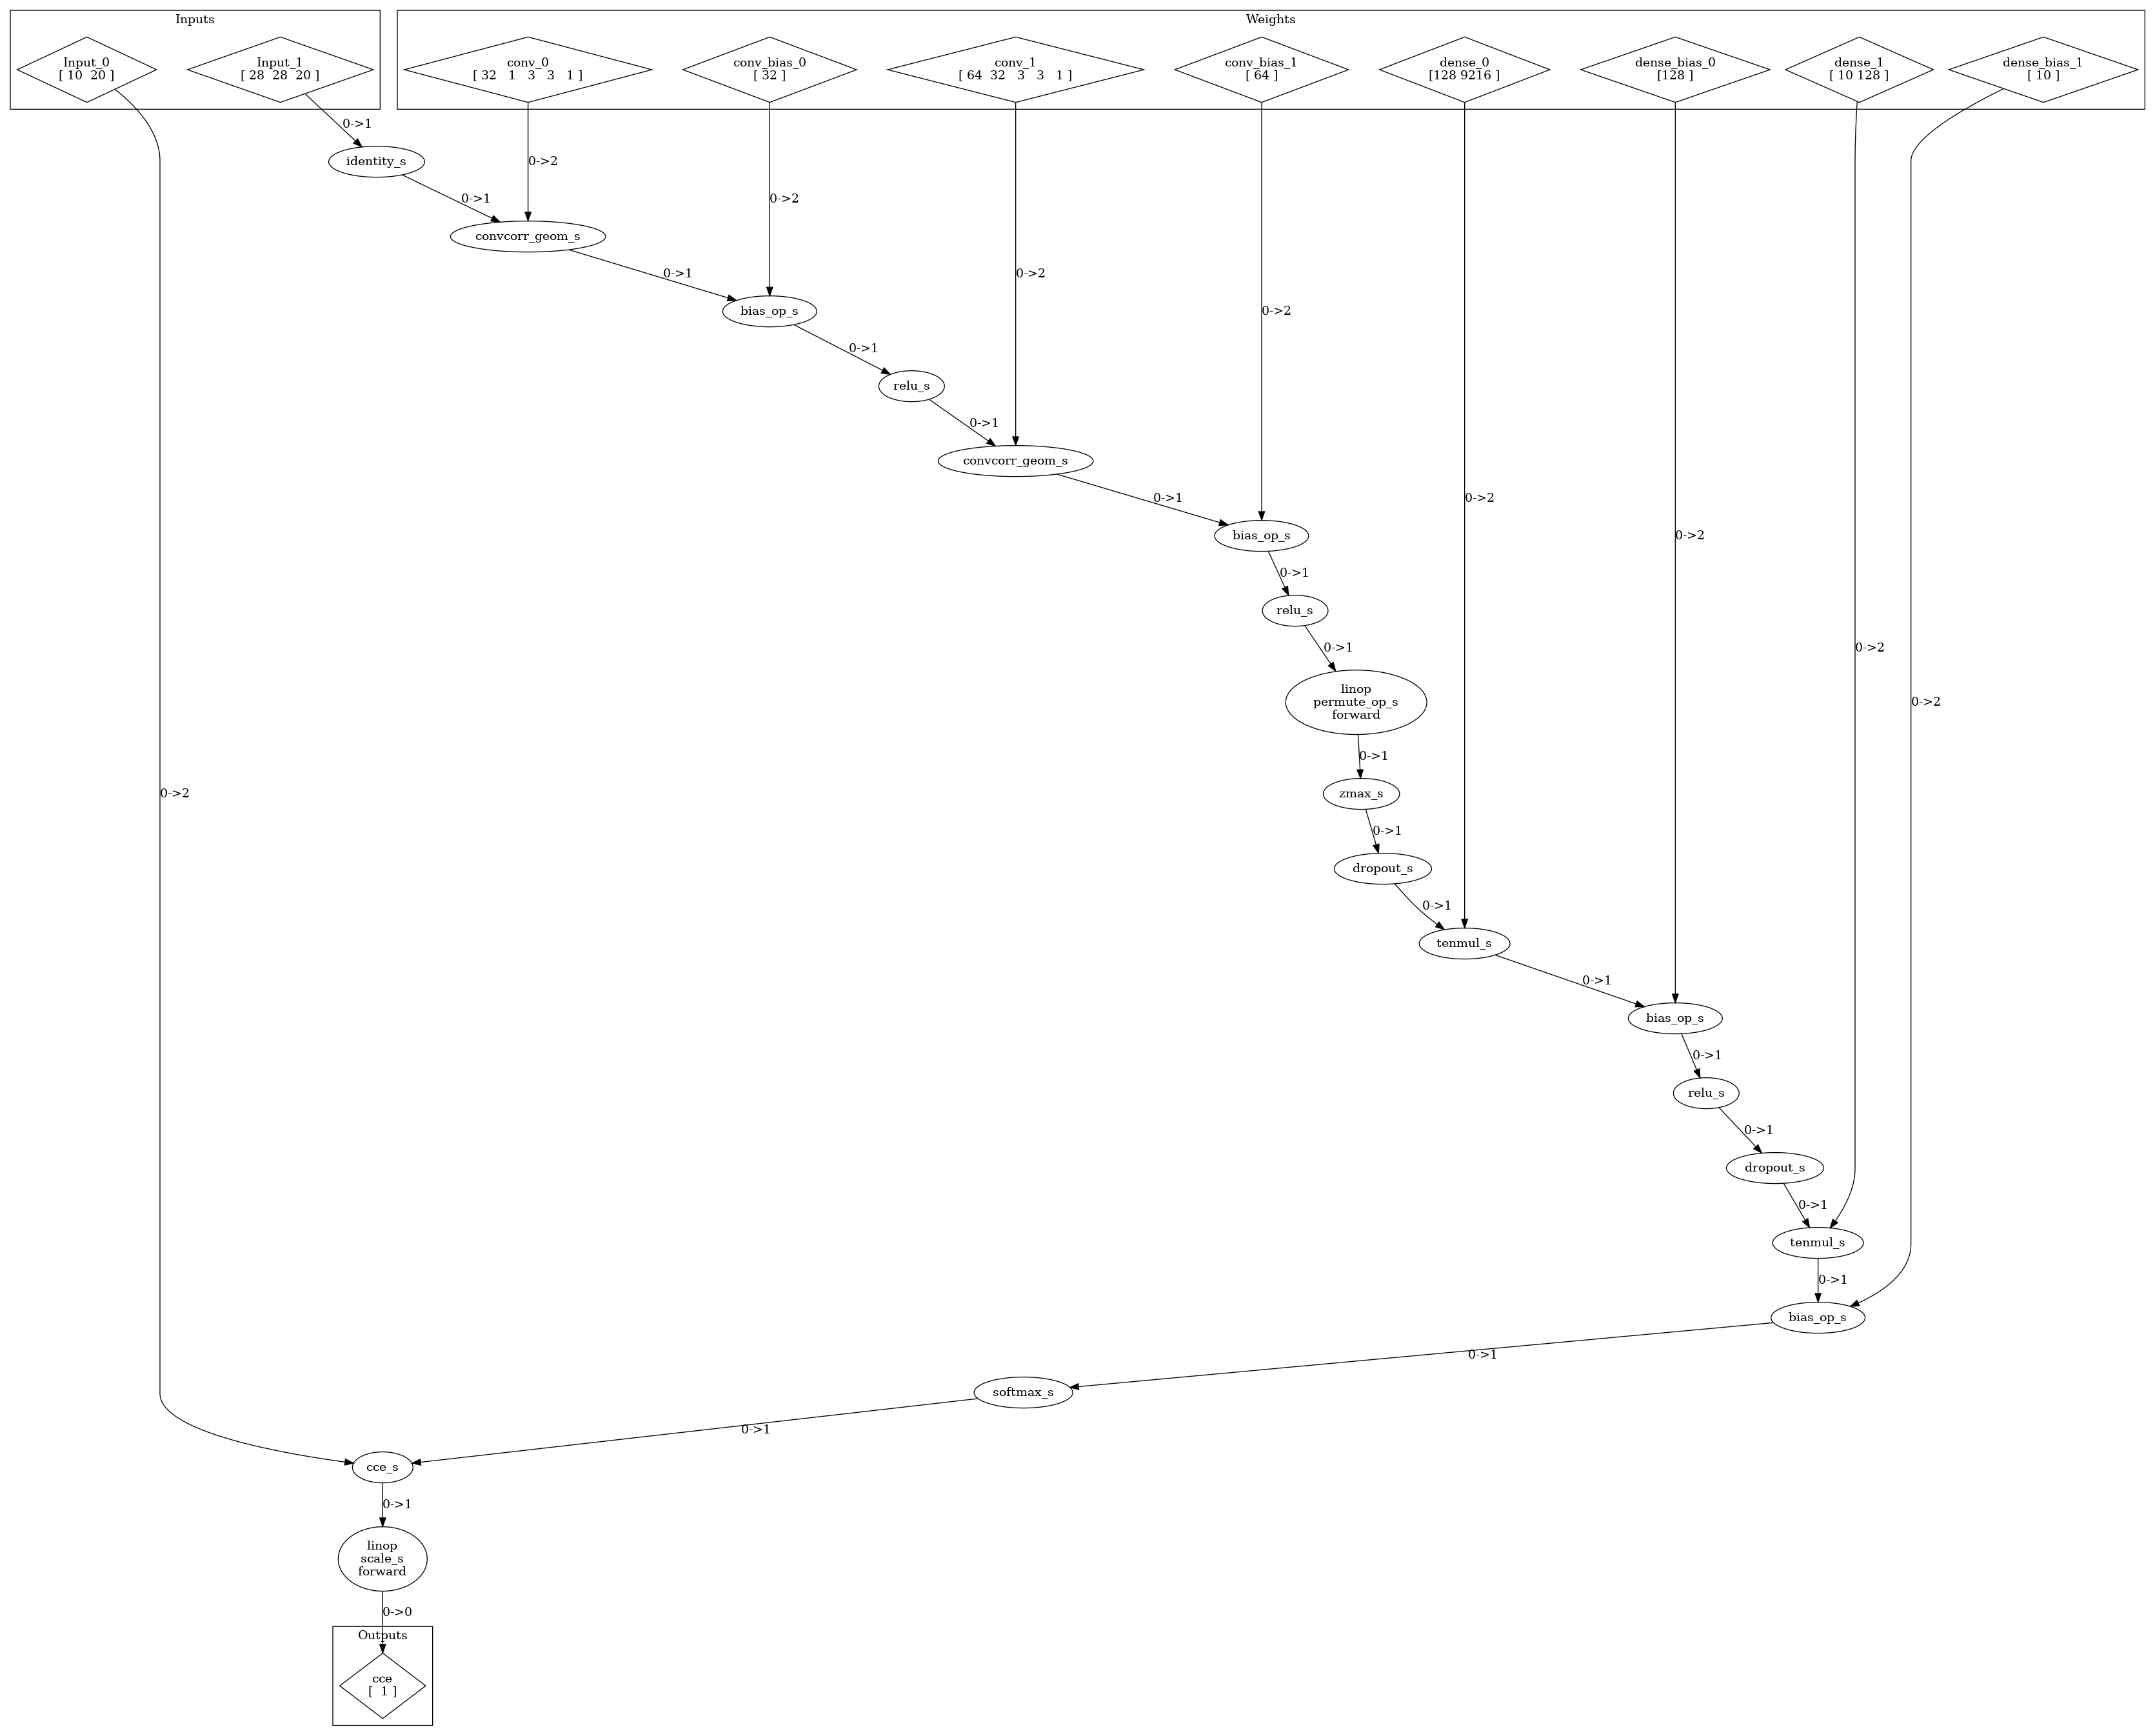

In [12]:
#!dot -Tpng mnist.dot>mnist_graph.png
display(Image(filename='mnist_graph.png'))

Finally, we run the training:

In [13]:
!bart nnet \
    --train \
    --network mnist \
    --train-algo epochs=2 \
    --batch-size 20 \
    --export-graph=mnist.dot \
    data/strain_images \
    weights/mnist \
    data/strain_labels

No training algorithm selected! Fallback to default settings.
Train Network
NN
inputs: 10
INDEX 0        [ 10  20 ]
INDEX 1        [ 28  28  20 ]
conv_0         [ 32   1   3   3   1 ]
conv_bias_0    [ 32 ]
conv_1         [ 64  32   3   3   1 ]
conv_bias_1    [ 64 ]
dense_0        [128 9216 ]
dense_bias_0   [128 ]
dense_1        [ 10 128 ]
dense_bias_1   [ 10 ]
outputs: 1
cce            [  1 ]
#1->10/10; [==========]; time: 0:00:03/0:00:03; loss: 2.125649;
#2->10/10; [==========]; time: 0:00:03/0:00:03; loss: 1.698826;


The weights file contains multiple multi-dimensional arrays:

In [14]:
%%bash

ls weights/mnist.*
echo ""
cat weights/mnist.hdr

weights/mnist.cfl
weights/mnist.hdr

# Dimensions
1199882 
# SizesDimensions
5 1 5 1 2 1 2 1 
# MultiDimensions
32 1 3 3 1 
32 
64 32 3 3 1 
64 
128 9216 
128 
10 128 
10 
# Command
nnet --train --network mnist --train-algo epochs=2 --batch-size 20 --export-graph=mnist.dot data/strain_images weights/mnist data/strain_labels 
# Files
 >weights/mnist <data/strain_labels <data/strain_images
# Creator
BART v0.7.00-126-g5287d1c


## 1.3 Evaluate the MNIST Network

To evaluate the trained network, we can apply it and compare with the reference using the `--eval` option:

In [15]:
%%bash

bart nnet \
    --eval \
    --network=mnist \
    data/stest_images \
    weights/mnist \
    data/stest_labels

cce: 1.695762e+00
weighted cce: 1.701791e+00
accuracy: 4.150001e-01
dice sim 0: 2.661541e-01
dice sim 1: 2.530864e-01
dice sim 2: 2.375777e-01
dice sim (label 0): 4.209262e-01
dice sim (label 1): 4.707048e-01
dice sim (label 2): 2.501713e-01
dice sim (label 3): 2.780337e-01
dice sim (label 4): 2.870868e-01
dice sim (label 5): 1.077290e-01
dice sim (label 6): 2.240009e-01
dice sim (label 7): 2.350219e-01
dice sim (label 8): 7.736599e-02
dice sim (label 9): 1.075349e-01

pred \ ref |   0   1   2   3   4   5   6   7   8   9| sum
-----------|----------------------------------------|----
0          |  11   0   0   0   1   0   0   0   0   0|  12
1          |   0  24   0   0   1   0   0   2   0   2|  29
2          |   6   0  16   3  12   6  19   9   5  12|  88
3          |   0   4   0  13   3  13   0   4   5   2|  44
4          |   0   0   0   0   9   0   0   0   0   0|   9
5          |   0   0   0   0   0   0   0   0   0   0|   0
6          |   0   0   0   0   0   0   1   0   0   0|   1
7   

For reasonable results, we need to train longer on the full dataset. We provide pretrained weights but you might generate them using:

In [16]:
#Train on larger dataset

#!bart nnet --train \
#    --network=mnist \
#    --train-algo epochs=10 \
#    --gpu \
#    data/train_images \
#    weights/weights_pretrained \
#    data/train_labels

In [17]:
%%bash

bart nnet \
    --eval \
    --network mnist \
    data/stest_images \
    weights/mnist_pretrained \
    data/stest_labels

cce: 1.675135e-02
weighted cce: 1.897817e-02
accuracy: 9.950000e-01
dice sim 0: 9.915991e-01
dice sim 1: 9.905235e-01
dice sim 2: 9.892071e-01
dice sim (label 0): 9.999428e-01
dice sim (label 1): 9.987715e-01
dice sim (label 2): 9.969270e-01
dice sim (label 3): 9.673957e-01
dice sim (label 4): 9.911047e-01
dice sim (label 5): 9.847385e-01
dice sim (label 6): 9.998627e-01
dice sim (label 7): 9.972964e-01
dice sim (label 8): 9.821129e-01
dice sim (label 9): 9.866426e-01

pred \ ref |   0   1   2   3   4   5   6   7   8   9| sum
-----------|----------------------------------------|----
0          |  17   0   0   0   0   0   0   0   0   0|  17
1          |   0  28   0   0   0   0   0   0   0   0|  28
2          |   0   0  16   0   0   0   0   0   0   0|  16
3          |   0   0   0  15   0   0   0   0   0   0|  15
4          |   0   0   0   0  28   0   0   0   0   0|  28
5          |   0   0   0   1   0  20   0   0   0   0|  21
6          |   0   0   0   0   0   0  20   0   0   0|  20
7   

## 1.4 Apply the MNIST Network

Finally, we can apply the network to predict labels using the `--apply` option. The one-hot encoded output is converted to integer encoded output by taking the entry with the maximum probability.

In [18]:
%%bash

bart nnet \
    --apply \
    --network=mnist \
    data/stest_images \
    weights/mnist_pretrained \
    mnist_onehot

bart onehotenc -r \
    mnist_onehot \
    mnist_integer

Input Images:


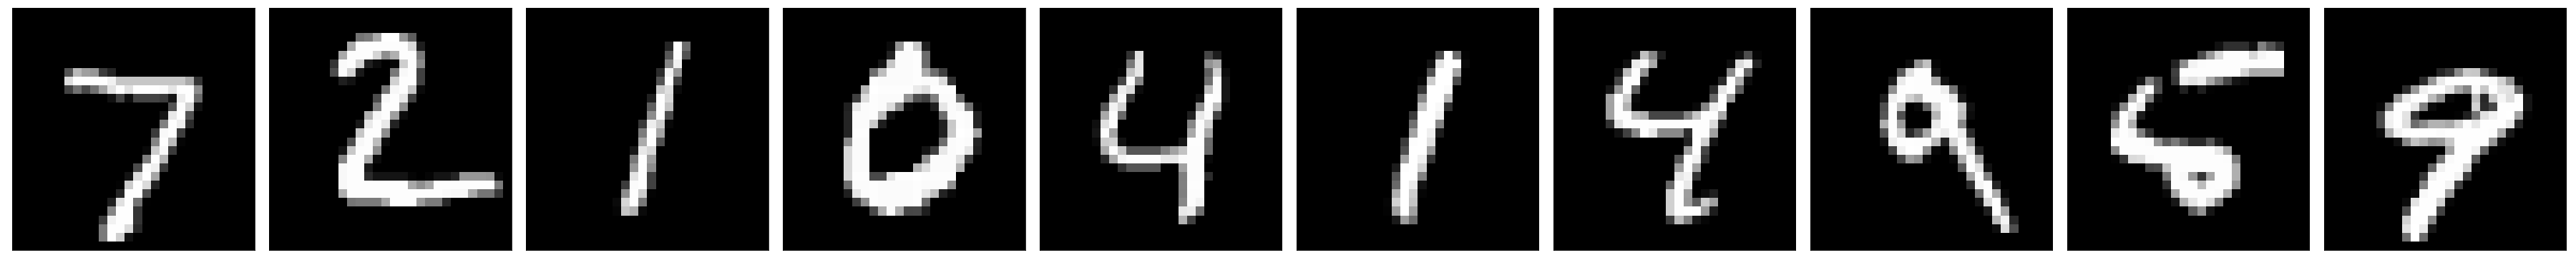


#One-Hot Encoding (mnist_onehot.hdr):
# Dimensions
10 200 

Probabilities:
[[2.e-10 1.e-10 6.e-09 9.e-09 2.e-12 5.e-12 5.e-15 1.e+00 3.e-11 1.e-07]
 [7.e-09 4.e-06 1.e+00 2.e-09 3.e-11 1.e-11 3.e-07 1.e-10 3.e-08 1.e-12]
 [2.e-09 1.e+00 3.e-08 5.e-10 4.e-06 4.e-08 4.e-07 9.e-07 1.e-07 3.e-08]
 [1.e+00 4.e-09 2.e-08 2.e-10 1.e-08 2.e-08 3.e-06 1.e-08 1.e-08 1.e-06]
 [4.e-10 5.e-08 1.e-08 5.e-11 1.e+00 4.e-10 5.e-09 7.e-09 3.e-08 1.e-04]
 [2.e-09 1.e+00 7.e-09 1.e-10 2.e-05 1.e-08 2.e-07 2.e-06 1.e-07 6.e-08]
 [2.e-09 2.e-06 4.e-08 6.e-09 1.e+00 5.e-07 6.e-07 1.e-06 8.e-04 1.e-03]
 [1.e-11 4.e-09 5.e-09 3.e-09 2.e-05 6.e-07 5.e-11 2.e-10 9.e-07 1.e+00]
 [8.e-07 1.e-09 1.e-10 2.e-08 3.e-08 1.e+00 2.e-03 6.e-11 1.e-04 5.e-06]
 [2.e-10 2.e-11 7.e-11 4.e-10 3.e-06 1.e-09 4.e-12 6.e-07 2.e-06 1.e+00]]

#Integer Encoding (mnist_integer.hdr):
# Dimensions
1 200 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

Predicted Labels:
[[7. 2. 1. 0. 4. 1. 4. 9. 5. 9.]]


In [19]:
!echo "Input Images:"
display(Image(filename='mnist_example.png')) 

!echo ""
!echo "#One-Hot Encoding (mnist_onehot.hdr):"
!head -n2 mnist_onehot.hdr
!echo ""

!echo "Probabilities:"

labels = cfl.readcfl("mnist_onehot")[:,:10]
np.set_printoptions(precision=0)
print(np.real(labels.transpose([1, 0])))

!echo ""
!echo "#Integer Encoding (mnist_integer.hdr):"
!head -n2 mnist_integer.hdr

!echo ""
!echo "Predicted Labels:"

labels = cfl.readcfl("mnist_integer")
np.set_printoptions(precision=0)
print(np.real(labels[:,:10]))


# PART II: Reconstruction Networks - bart reconet

Variational Network<sup>1</sup>:
$$ x^{(i)} = x^{(i-1)}  - \lambda \nabla||Ax -b||^2 + Net(x^{(i-1)}, \Theta^{(i)} )$$
MoDL<sup>2</sup>:
$$
\begin{align}
z^{(i)} &= Net\left(x^{(i-1)}, \Theta \right)\\
x^{(i)} &= \mathrm{argmin}_x ||Ax -b||^2 + \lambda ||x - z^{(i)}||^2
\end{align}
$$

Where
+ $A$ - MRI forward operator $\mathcal{PFC}$
    + $\mathcal{P}$ - Sampling pattern
    + $\mathcal{F}$ - Fourier transform
    + $\mathcal{C}$ - Coil sensitivity maps
+ $b$ - measured k-space data
+ $x^{(i)}$ - reconstruction after $i$ iterations
+ $x^{(0)}=A^Hb$ - initialization
+ $\Theta$ - Weights

1: Hammernik, K. et al. (2018), [Learning a variational network for reconstruction of accelerated MRI data](https://doi.org/10.1002/mrm.26977). Magn. Reson. Med., 79: 3055-3071.

2: Aggarwal, H. K. et al.(2019), [MoDL: Model-Based Deep Learning Architecture for Inverse Problems](https://doi.org/10.1109/TMI.2018.2865356). IEEE Trans. Med. Imag., 38(2): 394-405

To **train**, **evaluate** or **apply** unrolled networks, we provide the `bart reconet` command. It follows the same logic as the `bart nnet` command but gets the coil sensitivity maps as an additional input. Let us look at the help:

In [20]:
%%bash

bart reconet -h

Usage: reconet [-t,--train] [-e,--eval] [-a,--apply] [-g,--gpu] [-l,--load <file>] [-b,--batch-size d] [-I,--iterations d] [-n,--normalize] [-N,--network ...] [--resnet-block ...] [--varnet-block ...] [--unet ...] [--data-consistency ...] [--initial-reco ...] [--shared-weights] [--no-shared-weights] [--shared-lambda] [--no-shared-lambda] [--trajectory <file>] [--pattern <file>] [--valid-data ...] [--train-loss ...] [--valid-loss ...] [--multi-loss f] [-T,--train-algo ...] [--adam ...] [--iPALM ...] [--load-memory] [--lowmem] [--test] [--export-graph <string>] <kspace> <sens> <weights> <out/ref>

Trains or appplies a neural network for reconstruction.

-t,--train                   train reconet
-e,--eval                    evaluate reconet
-a,--apply                   apply reconet
-g,--gpu                     run on gpu
-l,--load <weights-init>     load weights for continuing training
-b,--batch-size d            size of mini batches
-I,--iterations d            number of unrolled iter

In [21]:
%%bash

bart reconet --network h

Usage of sub-option: -N,--network [modl],[varnet],[unet]

Sub-options: select neural network

modl      use MoDL Network (also sets train and data-consistency default values)
varnet    use Variational Network (also sets train and data-consistency default values)
unet      use U-Net (also sets train and data-consistency default values)
h         help


## 2.1 Prepare the Knee-Data

Here, we use the data provided with the publication of the Variational Network, i.e. the coronal_pd_fs folder of the NYU-Dataset. The data has been converted to the .cfl-file format. In the data folder, we find the fully sampled kspace-data of a knee and a sampling pattern. As the kspace is fully sampled, we can define a ground truth reference.
Before we apply the networks, we will create/estimate:
+ the downsampled kspace
+ coil sensitivity maps
+ a ground truth reference


# K-Space (fully sampled):
# Dimensions
640 368 1 15 1 1 1 1 1 1 1 1 1 1 1 1 

# Pattern:
# Dimensions
640 368 1 1 1 


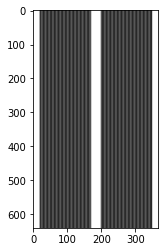

In [22]:
!echo $'\n# K-Space (fully sampled):'
!head -n2 data/kspace_fs.hdr

!echo $'\n# Pattern:'
!head -n2 data/pattern_po_4.hdr

pattern = np.abs(cfl.readcfl("data/pattern_po_4"))
plt.imshow(pattern, cmap="gray")
plt.show()

### 2.1.1 Create downsampled kspace

We downsample the fully sampled kspace by multiplying with the sampling pattern:

In [23]:
%%bash

bart fmac data/kspace_fs data/pattern_po_4 kspace

### 2.1.2 Estimate coil sensitivity maps

We estimate the coil sensitivity maps using ESPIRiT. 

In [24]:
%%bash

bart ecalib -r24 -m1 kspace coils_l
bart resize -c 0 320 coils_l coils

Done.


### 2.1.3 Reconstruct Reference

We construct the **ground truth reference** as the coil-combinded reconstruction of the fully sampled kspace data. For comparison, we also compute a **l1-wavelet** regularized and the **zero-filled** reconstruction.

In [25]:
%%bash

mkdir -p tmp

FFT_FLAG=$(bart bitmask 0 1)
COIL_FLAG=$(bart bitmask 3)

# Reference
bart fft -i -u $FFT_FLAG data/kspace_fs tmp/coil_image
bart fmac -C -s$COIL_FLAG tmp/coil_image coils_l tmp/image

# PICS l1
bart pics -S -l1 -r0.001 -pdata/pattern_po_4 kspace coils_l tmp/pics_reco_l
#resize (frequency oversampling)

# Zero-filled
bart fft -i -u $FFT_FLAG kspace tmp/coil_image_zf
bart fmac -C -s$COIL_FLAG tmp/coil_image_zf coils_l tmp/image_zf_l

#resize (frequency oversampling)
bart resize -c 0 320 tmp/image ref
bart resize -c 0 320 tmp/pics_reco_l pics_reco
bart resize -c 0 320 tmp/image_zf_l zero_filled

rm -r tmp

Size: 235520 Samples: 90880 Acc: 2.59
l1-wavelet regularization: 0.001000
FISTA
Total Time: 6.730073


We show the results:

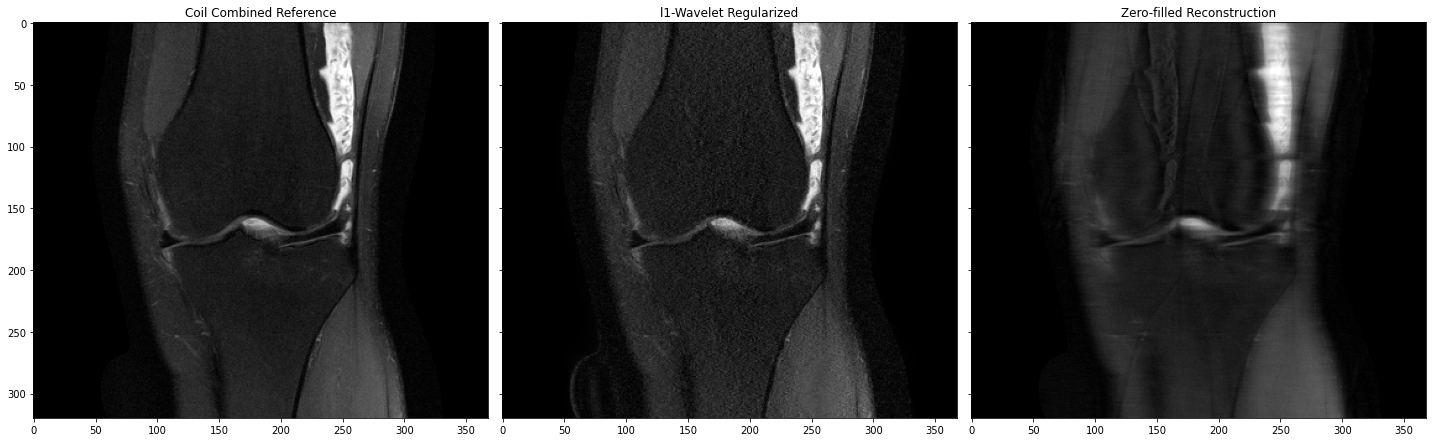

In [26]:
ref = cfl.readcfl("ref")
pics_reco = cfl.readcfl("pics_reco")
zero_filled = cfl.readcfl("zero_filled")

vmax=0.9*np.max(np.abs(ref))

fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=3, sharex=True, sharey=True)

axes[0].imshow(np.abs(ref[::-1,::-1]), cmap="gray", vmax=vmax)
axes[0].set_title("Coil Combined Reference")

axes[1].imshow(np.abs(pics_reco[::-1,::-1]), cmap="gray", vmax=vmax)
axes[1].set_title("l1-Wavelet Regularized")

axes[2].imshow(np.abs(zero_filled[::-1,::-1]), cmap="gray", vmax=vmax)
axes[2].set_title("Zero-filled Reconstruction")

plt.tight_layout()
plt.show()

## 2.2 Apply Variational Network

Having prepared the dataset, we can apply the Variational Network using the downloaded weights. The dataset is normalized by the maximum magnitude of the zero-filled reconstruction by the `--normalize` option. We use the pretrained weights provided in the weights directory. They have been trained on the first 15 knees from the coronal_pd_fs directory of the NYU-Dataset


In [27]:
%%bash

#GPU=--gpu; # if BART is compiled with gpu support, we add the --gpu option

bart reconet \
    $GPU \
    --network=varnet \
    --normalize \
    --apply \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    weights/varnet \
    varnet

Apply RecoNet
NN
inputs: 6
kspace         [640 368   1  15   1 ]
coil           [320 368   1  15   1 ]
pattern        [640 368   1   1   1 ]
lambda         [ 10 ]
conv           [ 24  11  11   1  10 ]
rbf            [ 24  31  10 ]
outputs: 1
INDEX 0        [320 368   1   1   1 ]


We plot the results:

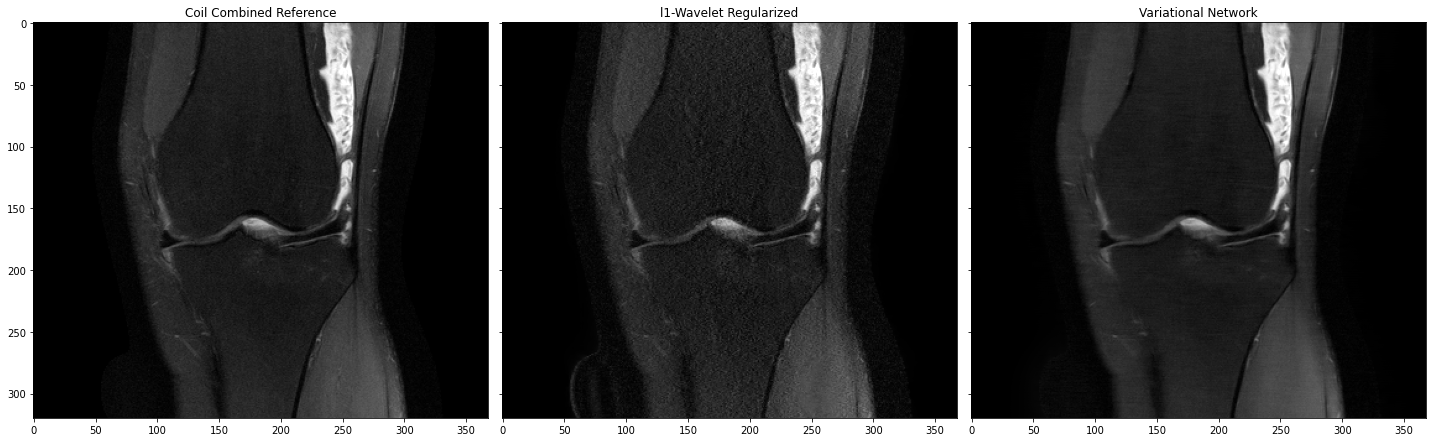

In [28]:
ref = cfl.readcfl("ref")
pics_reco = cfl.readcfl("pics_reco")
varnet = cfl.readcfl("varnet")

vmax=0.9*np.max(np.abs(ref))

fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=3, sharex=True, sharey=True)

axes[0].imshow(np.abs(ref[::-1,::-1]), cmap="gray", vmax=vmax)
axes[0].set_title("Coil Combined Reference")

axes[1].imshow(np.abs(pics_reco[::-1,::-1]), cmap="gray", vmax=vmax)
axes[1].set_title("l1-Wavelet Regularized")

axes[2].imshow(np.abs(varnet[::-1,::-1]), cmap="gray", vmax=vmax)
axes[2].set_title("Variational Network")

plt.tight_layout()
plt.show()

## 2.3 Apply MoDL

Similarly, MoDL can be applied using the provided weights. Here, we unroll 5 iterations.

In [29]:
%%bash

#GPU=--gpu; # if BART is compiled with gpu support, we add the --gpu option

bart reconet \
    $GPU \
    --network=modl \
    --iterations=5 \
    --normalize \
    --apply \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    weights/modl \
    modl

Apply RecoNet
NN
inputs: 14
kspace         [640 368   1  15   1 ]
coil           [320 368   1  15   1 ]
pattern        [640 368   1   1   1 ]
lambda         [  1 ]
conv_0         [ 32   1   3   3   1   1 ]
conv_i         [ 32  32   3   3   1   3   1 ]
conv_n         [  1  32   3   3   1   1 ]
bias_0         [ 32   1 ]
bias_i         [ 32   3   1 ]
bias_n         [  1   1 ]
gamma          [  1   1   1   1   1   5 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]
outputs: 4
INDEX 0        [320 368   1   1   1 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]


We plot the results:

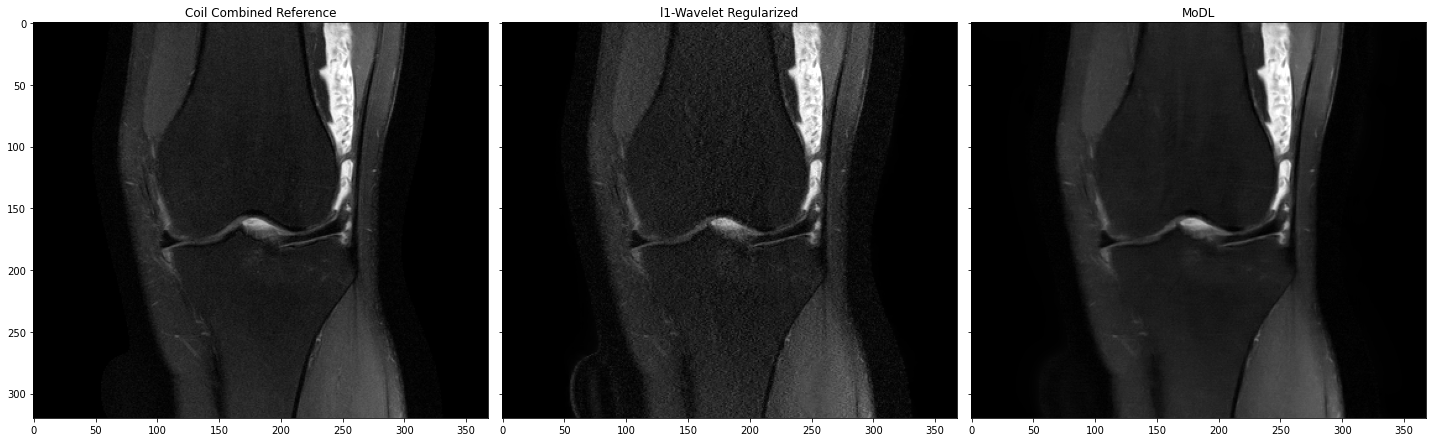

In [30]:
ref = cfl.readcfl("ref")
pics_reco = cfl.readcfl("pics_reco")
modl = cfl.readcfl("modl")

vmax=0.9*np.max(np.abs(ref))

fig, axes = plt.subplots(figsize=(20,6), nrows=1, ncols=3, sharex=True, sharey=True)

axes[0].imshow(np.abs(ref[::-1,::-1]), cmap="gray", vmax=vmax)
axes[0].set_title("Coil Combined Reference")

axes[1].imshow(np.abs(pics_reco[::-1,::-1]), cmap="gray", vmax=vmax)
axes[1].set_title("l1-Wavelet Regularized")

axes[2].imshow(np.abs(modl[::-1,::-1]), cmap="gray", vmax=vmax)
axes[2].set_title("MoDL")

plt.tight_layout()
plt.show()

## 2.4 Evaluation of the Variational Network and MoDL

In [31]:
%%bash

#GPU=--gpu; # if BART is compiled with gpu support, we add the --gpu option

bart reconet \
    $GPU \
    --network=varnet \
    --normalize \
    --eval \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    weights/varnet \
    ref 

Apply RecoNet
NN
inputs: 6
kspace         [640 368   1  15   1 ]
coil           [320 368   1  15   1 ]
pattern        [640 368   1   1   1 ]
lambda         [ 10 ]
conv           [ 24  11  11   1  10 ]
rbf            [ 24  31  10 ]
outputs: 1
INDEX 0        [320 368   1   1   1 ]
mse smoothed magnitunde: 3.780674e-12
mse: 7.128182e-12
mean psnr: 3.830919e+01
mean ssim: 9.022023e-01


In [32]:
%%bash

#GPU=--gpu; # if BART is compiled with gpu support, we add the --gpu option

bart reconet \
    $GPU \
    --network=modl \
    --iterations=5 \
    --normalize \
    --eval \
    --pattern=data/pattern_po_4 \
    kspace \
    coils \
    weights/modl \
    ref 

Apply RecoNet
NN
inputs: 14
kspace         [640 368   1  15   1 ]
coil           [320 368   1  15   1 ]
pattern        [640 368   1   1   1 ]
lambda         [  1 ]
conv_0         [ 32   1   3   3   1   1 ]
conv_i         [ 32  32   3   3   1   3   1 ]
conv_n         [  1  32   3   3   1   1 ]
bias_0         [ 32   1 ]
bias_i         [ 32   3   1 ]
bias_n         [  1   1 ]
gamma          [  1   1   1   1   1   5 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]
outputs: 4
INDEX 0        [320 368   1   1   1 ]
bn_0           [ 32   1   1   1   1   2   5 ]
bn_i           [ 32   1   1   1   1   2   3   5 ]
bn_n           [  1   1   1   1   1   2   5 ]
mse smoothed magnitunde: 4.120224e-12
mse: 7.402647e-12
mean psnr: 3.787887e+01
mean ssim: 8.740520e-01
